# Predicting the market using neural networks.

Name: Royce Mathew <br />
Student Id: 100823686

## Introduction
___



Predicting the market can be quite hard for a neural network to understand due to the properties of the market. To perfectly predict the market, the neural network would need a high number of parameters and training. 

This paper tries to explore the question on whether a neural network is able to predict the market given a limited set of parameters.

The program works by using neural networking algorithm known as NEAT. **"NEAT"** stands for **"Neural Networks through Augmented Topologies"**. The `neat` algorithm works by using the concept of life, where each generation starts to learn based on the last generations.

A proper explanation of how the algorithm works can be found on https://www.cs.ucf.edu/~kstanley/neat.html.

## Retrieving / Downloading Forex Charts

---

To start, we'll retrieve the data using a public module which imports data from yahoo.finance and automatically converts it into a csv file.
<br>
### Download Data
To download the data of the chart, we'll use yfinance to download and save the data as a csv file. 
This piece of code saves the data as a .csv file.

```py
# Imports
from matplotlib import ticker
import yfinance as yf

# Variables
ticker_name: str = "JPY=X" # "JPY=X"


# Download ticker data
ticker_data = yf.download(
    tickers=ticker_name, # Set ticker as variable
    period="max", # Get as much data as possible
)

ticker_data.to_csv(f"./../assets/{ticker_name}.csv") # Save dataframe as a csv file

ticker_data # Display Ticker Data
```

### Retrieving Data
To retrieve the data, we'll use pandas pull the file from the github repository. Pandas automatically takes care of making the web request.

In [1]:
import pandas as pd
import http.client as client # Need to read text file

# Use links to store data
assets_path: str = "https://github.com/royce-mathew/data/raw/master"

# Pandas automatically makes the request
ticker_data: pd.DataFrame = pd.read_csv(f"{assets_path}/JPY=X.csv", index_col=0)
# Test data


# TO DO: Import config with requests too
ticker_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-10-30,114.370003,114.480003,113.610001,114.180000,114.180000,0
1996-11-01,113.500000,113.500000,113.500000,113.500000,113.500000,0
1996-11-04,113.279999,113.980003,112.949997,113.879997,113.879997,0
1996-11-05,113.709999,114.330002,113.449997,114.250000,114.250000,0
1996-11-06,114.230003,114.680000,113.650002,113.949997,113.949997,0
...,...,...,...,...,...,...
2022-11-07,146.841003,147.552994,146.113998,146.841003,146.841003,0
2022-11-08,146.623993,146.927002,145.313004,146.623993,146.623993,0
2022-11-09,145.294998,146.557999,145.218994,145.294998,145.294998,0


### Plotting Initial Data
___

For plotting the initial data, pandas.plot is used. Pandas.plot internally uses matplotlib to plot data. 

This plot displays the adjusted close price for each day.

<AxesSubplot: xlabel='Date'>

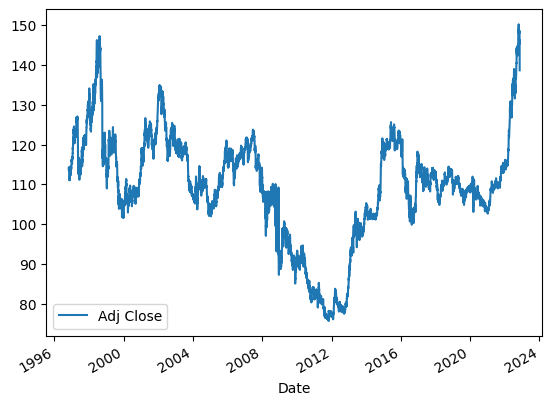

In [2]:
# Plot the data
ticker_data.index = pd.to_datetime(ticker_data.index) # Convert the index to a datetime value
ticker_data.plot.line(y="Adj Close", use_index=True)

## Data Analysis

---

To use NEAT, we need to convert the ticker data and optimize the parameters we pass to it. 

We need to show the algorithm some trends in the data so it is able to learn patterns, so we pass the algorithm:
- RSI: Relative strength index
- EMA: Exponential moving averages
- Close Ratios: The ratio of the current close by the rolling averages of the past closes
- Trend Horizons: Currebt trend of profits / losses


After filling the dataset with all these values, the program minmaxes all the values to be between 0 and 1, generally considered good practise for inputs in machine learning.

In [3]:
import pandas_ta as ta # We use pandas_ta to see trends in the ticker data
from sklearn.preprocessing import MinMaxScaler # Used to scale values between 0 and 1

# Insert new rows to the ticker data using pandas_ta
"""
    RSI tells us overbought / oversold conditions in the market
    EMAF tells us the exponential moving average

    The rolling averages will tell us whether the market has gone up or down
"""
horizons: list[int] = [2, 5, 60, 250, 1000] # The mean closing prices we'll use; 2days, 5days, ... 

def convert_dataframe(dataframe) -> pd.DataFrame:
    dataframe.reset_index(inplace=True) # Reset index of dataframe, this gives us an index of integers instead of Dates
    dataframe.drop(["Volume", "Close", "Date", "High", "Low"], axis=1, inplace=True) # Drop unneeded columns


    # Create new rows to see target value for tomorrow; this is used to train the model
    dataframe["Target"] = dataframe["Adj Close"] - dataframe["Open"] # Calculate whether the value increased or decreased
    dataframe["Target"] = dataframe["Target"].shift(-1) # Shift the target by - 1 so we know tomorrow's target
    dataframe["TargetClass"] = (dataframe["Target"] > 0).astype(int) # Classify buy/sell

    dataframe["RSI"] = ta.rsi(dataframe["Adj Close"], length=15) 
    dataframe["EMAM"] = ta.ema(dataframe["Adj Close"], length=100)
    dataframe["EMAF"] = ta.ema(dataframe["Adj Close"], length=20) 
    dataframe["EMAS"] = ta.ema(dataframe["Adj Close"], length=150)

    for horizon in horizons: # Loop through these closing prices and add them as a column 
        rolling_averages: pd.DataFrame = dataframe.rolling(horizon).mean() 

        # Add to the dataframe
        ratio_column: str = f"Close Ratio {horizon}"
        dataframe[ratio_column] = dataframe["Adj Close"] / rolling_averages["Adj Close"]

        trend_column: str = f"Trend {horizon}"
        dataframe[trend_column] = dataframe.shift(1).rolling(horizon).sum()["TargetClass"]


    # Drop Missing Values
    dataframe.dropna(inplace=True)
    dataframe.reset_index(inplace=True) # Reset index again because we dropped null values
    dataframe.drop(["index"], axis=1, inplace=True)

    scaled_data: pd.DataFrame = dataframe.copy(deep=True) # Deep Copy 
    scaled_data.drop(["Open", "Target", "TargetClass"], axis=1, inplace=True) # Only give the model values it will know in the real world
    # Optimize data range between 0 to 1 for the model
    scaled_data = MinMaxScaler(feature_range=(0,1)).fit_transform(scaled_data)

    return scaled_data



scaled_data = convert_dataframe(ticker_data) # Convert dataframe with important values

ticker_data

,Open,Adj Close,Target,TargetClass,RSI,EMAM,EMAF,EMAS,Close Ratio 2,Trend 2,Close Ratio 5,Trend 5,Close Ratio 60,Trend 60,Close Ratio 250,Trend 250,Close Ratio 1000,Trend 1000
0,106.889999,106.949997,-0.419998,0,49.301083,107.222479,106.878933,107.345713,1.000281,1.0,0.998469,3.0,0.994575,28.0,1.005433,123.0,0.900874,504.0
1,107.019997,106.599998,0.089996,1,46.260185,107.210152,106.852368,107.335836,0.998361,1.0,0.996057,2.0,0.991133,27.0,1.002170,122.0,0.897978,504.0
2,106.550003,106.639999,1.540001,1,46.663032,107.198862,106.832142,107.326620,1.000188,1.0,0.997867,2.0,0.991285,28.0,1.002567,123.0,0.898370,504.0
3,106.459999,108.000000,-0.279999,0,58.103726,107.214726,106.943367,107.335539,1.006336,2.0,1.009195,3.0,1.003618,28.0,1.015335,123.0,0.909875,504.0
4,107.930000,107.650002,-0.290001,0,54.859112,107.223346,107.010665,107.339704,0.998377,1.0,1.004498,3.0,1.000076,28.0,1.012011,123.0,0.906974,504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5744,148.393005,148.393005,0.000000,0,58.506755,140.449909,147.339601,136.825016,1.001691,0.0,1.001642,0.0,1.035956,0.0,1.155986,38.0,1.309458,403.0
5745,146.841003,146.841003,0.000000,0,51.110192,140.576465,147.292116,136.957678,0.994743,0.0,0.992467,0.0,1.023507,0.0,1.142731,38.0,1.295316,403.0
5746,146.623993,146.623993,0.000000,0,50.160168,140.696218,147.228485,137.085709,0.999261,0.0,0.993839,0.0,1.020396,0.0,1.139913,38.0,1.292967,402.0
5747,145.294998,145.294998,0.000000,0,44.707453,140.787283,147.044343,137.194441,0.995447,0.0,0.988341,0.0,1.009857,0.0,1.128523,38.0,1.280834,402.0


## Plotting input data

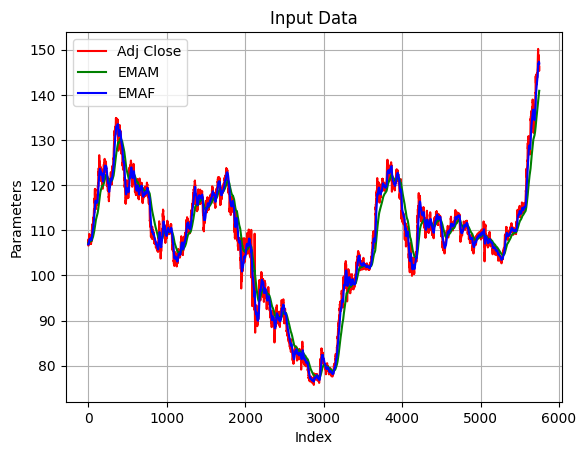

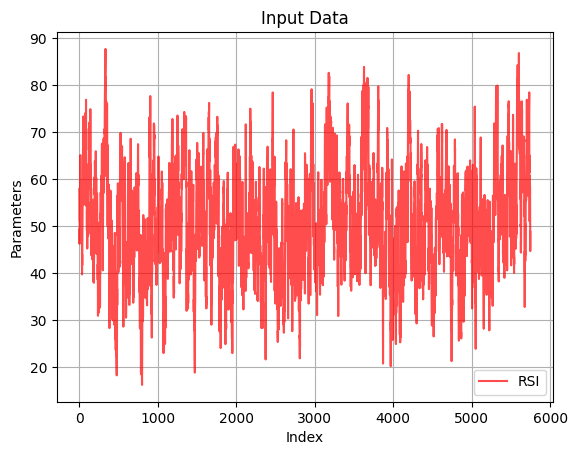

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def input_plot():
    index = range(len(scaled_data))

    # Plot values
    plt.plot(index, ticker_data["Adj Close"], 'r', label="Adj Close")
    plt.plot(index, ticker_data["EMAM"], 'g', label="EMAM")
    plt.plot(index, ticker_data["EMAF"], 'b', label="EMAF")
    plt.title("Input Data")
    plt.xlabel("Index")
    plt.ylabel("Parameters")
    plt.grid()
    plt.legend(loc="best")
    plt.show()


    plt.figure()
    plt.plot(index, ticker_data["RSI"], 'r', label="RSI", alpha=0.7)



    # Add Labels
    plt.title("Input Data")
    plt.xlabel("Index")
    plt.ylabel("Parameters")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

input_plot() # Plot the inputs

## Plotting the Statistics

---

To plot the statistics of the neural network, matplotlib is used while the neat module gives us most of the info needed to create the charts.

This plot displasy the fitness of each each generation. The fitness attribute is given to a genome when it starts making profits by predicting the outcome of the future closes. 

In [5]:
%matplotlib inline

# Plotting the statistics
def plot_statistics(stats):
    generation = range(len(stats.most_fit_genomes))
    best_fitness = [c.fitness for c in stats.most_fit_genomes] # Get best fitnessses in each generation
    avg_fitness = np.array(stats.get_fitness_mean()) # Get the average fitness of the generation
    stdev_fitness = np.array(stats.get_fitness_stdev()) # Ge the standard deviation of the fitness

    # Plot values
    plt.plot(generation, avg_fitness, 'b-', label="average")
    plt.plot(generation, avg_fitness - stdev_fitness, 'g-.', label="-1 std", alpha=0.5)
    plt.plot(generation, avg_fitness + stdev_fitness, 'g-.', label="+1 std", alpha=0.5)
    plt.plot(generation, best_fitness, 'r-', label="best")

    # Add Labels
    plt.title("Profits vs Generation")
    plt.xlabel("Generations")
    plt.ylabel("Profits")
    plt.grid()
    plt.legend(loc="best")
    plt.show()

## Training The Model
---

The model is trained using the intial data that was was declared as a dataframe. 

The training works by essentially telling the giving the genome today's close and rewarding it fitness based on the prediction it makes.

The genome is passed all the values in the scaled_data dataframe with the state that it is currently in. The genome gains a very small amount of fitness for holding onto a trade while the value of that trade increases.


There are 3 outputs that the genome gives:
- Index 0: represents a hold state
- Index 1: represents a buy state
- Index 2: represents a sell state 

The genome is not allowed to gain negative profits and is removed from the population if it starts gaining negative profits.

Saving checkpoint to neat-checkpoint-9
Saving checkpoint to neat-checkpoint-19
Saving checkpoint to neat-checkpoint-28
Saving checkpoint to neat-checkpoint-37
Saving checkpoint to neat-checkpoint-45
Saving checkpoint to neat-checkpoint-54
Saving checkpoint to neat-checkpoint-63
Saving checkpoint to neat-checkpoint-73
Saving checkpoint to neat-checkpoint-83
Saving checkpoint to neat-checkpoint-95
Saving checkpoint to neat-checkpoint-108
Saving checkpoint to neat-checkpoint-123
Saving checkpoint to neat-checkpoint-137
Saving checkpoint to neat-checkpoint-153
Saving checkpoint to neat-checkpoint-167
Saving checkpoint to neat-checkpoint-182
Saving checkpoint to neat-checkpoint-198


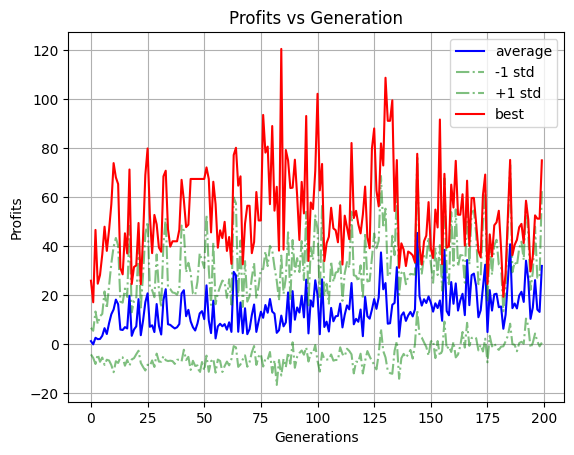

In [7]:
%matplotlib inline
import math
import multiprocessing
import neat
import pickle
import random
import time
import visualize


config_path: str = "../assets/neat-config.txt"

class Forex:
    def __init__(self) -> None:
        self.bought_for: float = 0
        self.held_for: float = 0
        self.bought: int = 0
    
    def buy(self, bought_for) -> None:
        if self.bought != 1:
            self.bought_for = bought_for
            self.bought = 1


    def check_value(self, current_value) -> float:
        if self.bought == 1:
            return current_value - self.bought_for
        else:
            return 0


    def hold(self) -> None:
        self.held_for += 1


    def sell(self, sold_for) -> float:
        to_return: float = sold_for - self.bought_for
        
        if self.bought_for == 0: # Don't return anything if we haven't bought yet
            return 0
        else:
            self.bought_for = 0 # Reset trade
            self.bought = 0

        return to_return


def evaluate_genomes(genomes, config) -> None:
    networks: list = []
    genome_list: list = []
    money_list: list = []

    index: int = random.randint(0, len(ticker_data) - 1000) # Make model learn from random index each iteration ?
    
    for genome_id, genome in genomes:
        genome.fitness = 0 # Start every genome with a fitness of 0
        # Append the net to the nets list
        networks.append(neat.nn.FeedForwardNetwork.create(genome, config))  # Neat.NeuralNetwork.FeedForwardNetwork
        genome_list.append(genome) # append each genome to the genome list, when genome list is empty go to the next generation
        money_list.append(Forex()) 

    # Loop until end dataframe's end
    while index < len(ticker_data):
        process_data = scaled_data[index] # MinMaxed data
        target = ticker_data.T[index][2] # Difference between today's close and tomorrows close
        target_c = ticker_data.T[index][3] # Positive/ Negative, tells whether we should've bought or sold
        current_close = ticker_data.T[index][1]

       # Loop through list of people
        for x, model in enumerate(genome_list):
            money: Forex = money_list[x]
            # Make prediction
            prediction = networks[x].activate(np.append(process_data, money.bought))
            decision = prediction.index(max(prediction))

            # Main Logic
            match decision:
                case 0: # Hold trade
                    money.hold() # Hold the stock
                    if money.check_value(current_close) > 0: #  If money starts gaining value
                        model.fitness += 0.0001


                case 1: # Buy
                    if money.bought_for == 0: # If we haven't already bought a stock yet
                        money.buy(current_close) # Buy a new stock

                case 2: # Sell
                    profit: float = money.sell(current_close) # Sell the stock

                    # Profit is only 0 when we haven't bought yet
                    if profit != 0:
                        model.fitness += profit

            # If the model has negative fitness
            if model.fitness < 0:
                networks.pop(x) # Remove model from this generation
                genome_list.pop(x)
                money_list.pop(x)

        
        # Go to the next row if there are no people left
        if len(genome_list) > 0:
            index += 1 # Go to next day
        else:
            break


def train_model(checkpoint = None, generations: int = 1000) -> None:
    # Set neat config
    config: neat.Config = neat.Config(
        neat.DefaultGenome, neat.DefaultReproduction, 
        neat.DefaultSpeciesSet, neat.DefaultStagnation,
        config_path
    )

    # Initialize Population Variable
    population: neat.Population;

    # Check if checkpoint parameter was passed
    if checkpoint is not None:
        try:
            population = neat.Checkpointer.restore_checkpoint(f"neat-checkpoint-{checkpoint}")
        except FileNotFoundError:
            print(f"File \"neat-checkpoint-{checkpoint}\" not found, starting from generation 0")
            population = neat.Population(config=config)
    else:
        population = neat.Population(config=config)


    # Add reporters (Testing purposes)
    networkStatistics = neat.StatisticsReporter()
    population.add_reporter(neat.Checkpointer(2000))
    # population.add_reporter(neat.StdOutReporter(True))
    population.add_reporter(networkStatistics)

    # Run the population
    best_node = population.run(evaluate_genomes, generations)

    plot_statistics(networkStatistics) # Plot the statistics after we are finished 1000 generations

    # Save the best node in a pickle file
    with open("../assets/best.pickle", "wb") as file:
        pickle.dump(best_node, file)


# load_best(config_path)
train_model(generations=200)

## Testing
---
The best genome can be tested on the decisions it chooses each day. 

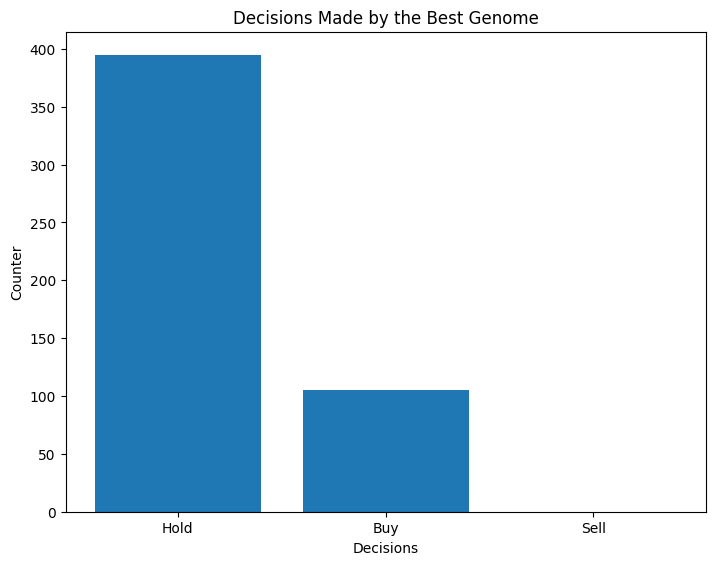

Total profit made by best genome: 0
Time it took to test genome: 55.97286248207092


In [14]:
index: int = 222 # Index to start testing from
test_data_len: int = 500 # Number of days to test
total_profit: float = 0 # The profit the genome has made
test_data = pd.read_csv(f"{assets_path}/INR=X.csv", index_col=0) # Use microsoft as test data
test_scaled = convert_dataframe(test_data) # Convert dataframe so we can send it to the model
genome_money = Forex() # Initialize a new object to hold profit statistics for current genome
decision_counter = [0, 0, 0]
decisions = ["Hold", "Buy", "Sell"]


# Test a specific genome
def test_genome(genome=None, process_data=None) -> int:
    # Error catching
    if process_data is None: # Catch errors if the process data isnt passed
        raise Exception("Error, process data is needed.") 

    if genome is None: # If genome isn't passed, use the best.pickle
        try:  # Catch any errors when trying to open the best.pickle file
            with open("../assets/best.pickle", "rb") as f:
                genome = pickle.load(f)
        except FileNotFoundError:
            print("(best.pickle) File not found, please load the file and try again")
            return -1
        except:
            print("Unknown error occured")
            return -1

    # Declare config 
    config = neat.Config(
        neat.DefaultGenome, neat.DefaultReproduction, 
        neat.DefaultSpeciesSet, neat.DefaultStagnation,
        config_path
    )

    population = neat.Population(config) # Start a new population with the config
    network: neat.nn.FeedForwardNetwork = neat.nn.FeedForwardNetwork.create(genome=genome, config=config) # Get the network passed and feed it this genome

    # Predictions
    prediction: list[float] = network.activate(process_data)
    decision: float = prediction.index(max(prediction))

    return decision

test_start_time = time.time()
for i in range(test_data_len): # Loop through test data
    genome_decision = test_genome(process_data=np.append(test_scaled[i], genome_money.bought)) # Transpose the test data and send the second last index
    current_close: float = test_data["Adj Close"].get(i)  # type: ignore

    decision_counter[genome_decision] += 1 # Increase the decision counter by 1
    match genome_decision:
        case 0: # Hold trade
            genome_money.hold() # Hold the stock

        case 1: # Buy
            if genome_money.bought_for == 0: # If we haven't already bought a stock yet
                genome_money.buy(current_close) # Buy a new stock

        case 2: # Sell
            total_profit += genome_money.sell(current_close) # Sell the stock


bar_figure = plt.figure() # Create new Figure
bar_axis = bar_figure.add_axes([0,0,1,1]) # Add Axes to the figre
bar_axis.bar(decisions, decision_counter) # Add the values
plt.xlabel("Decisions")
plt.ylabel("Counter")
plt.title("Decisions Made by the Best Genome")
plt.show() # Show the figure


print(f"Total profit made by best genome: {total_profit}") # Print profit made by genome
print(f"Time it took to test genome: {time.time() - test_start_time}")

## Discussion


As the data shows, during learning, the genome's profits stay erratic between each generation and do not increase at a linear rate. To create a more efficient algorithm, the data that is passed to the neat algorithm would need to be more correlated. More computing power is needed to see progress in profits.


During testing, the best genome in all 200 generations is not able to create a profit at all with a new and different dataset. As displayed by the bar graph shown above, the neural network decides to mostly make hold decisions because it thinks that the longest way to survive is by holding. The neural network also decides to buy approximately 100 times but never decides to close the trade.

The current neat algorithm, although efficient, is not smart enough to predict Forex Charts based on pure trends in the data. 